# Task for Today  

***

## Legendary Pokémon Classification  

Use a FeedForward Neural Network to predict if a given Pokémon is **legendary** or not, based on *Pokémon features*.


<img src="https://wallpapers.com/images/hd/legendary-pokemon-pictures-7yo7x0f1l2b2tu0r.jpg" width="800" height="500" alt="legendaries">

Data available at: https://github.com/Vaeliss/Pokemon_challenge/blob/main/pokemon.csv

Download the `pokemon.csv` file and put it in the file section of Colab.

# Challenge

TAs want to battle!

<img src="https://pokemongohub.net/wp-content/uploads/2023/06/grunts-1.jpg" width="400" height="300" alt="TAs">

Rules of the challenge:

- Gotta catch 'em all! ...But give priority to the legendaries.
- F1-score is usually the measure of choice for imbalanced datasets; however in this case we particularly want to avoid not "catching" legendaries. They're so rare, you might not have any more chances to catch 'em if they flee...
- In ML terms, we give recall more importance than precision for the task (check the whiteboard if you don't know their meaning).
- F2-score (i.e., [F-$\beta$-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) with $\beta = 2$) is hence used as the main evaluation metric for your model.

- **TAs achieved a F2-score of 0.80. Can you beat them?!**

# Imports and dataset

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

In [14]:
_ = torch.manual_seed(42) # for a fair comparison, don't change the seed!

In [15]:
data = pd.read_csv('./Datasets/pokemon.csv')

In [16]:
data

,dexnum,name,generation,type1,type2,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary
0,1025,Pecharunt,9,Poison,Ghost,0.3,0.3,88,88,160,88,88,88,600,1
1,1024,Terapagos,9,Normal,NaN,0.2,6.5,90,65,85,65,85,60,450,1
2,1023,Iron Crown,9,Steel,Psychic,1.6,156.0,90,72,100,122,108,98,590,0
3,1022,Iron Boulder,9,Rock,Psychic,1.5,162.5,90,120,80,68,108,124,590,0
4,1021,Raging Bolt,9,Electric,Dragon,5.2,480.0,125,73,91,137,89,75,590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,5,Charmeleon,1,Fire,NaN,1.1,19.0,58,64,58,80,65,80,405,0
1021,4,Charmander,1,Fire,NaN,0.6,8.5,39,52,43,60,50,65,309,0
1022,3,Venusaur,1,Grass,Poison,2.0,100.0,80,82,83,100,100,80,525,0
1023,2,Ivysaur,1,Grass,Poison,1.0,13.0,60,62,63,80,80,60,405,0


In [17]:
data_raw = data.copy() # usually, if memory allows it, it's a good idea to keep a raw version of your data

# Pre-processing / encoding

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dexnum      1025 non-null   int64  
 1   name        1025 non-null   object 
 2   generation  1025 non-null   int64  
 3   type1       1025 non-null   object 
 4   type2       526 non-null    object 
 5   height      1025 non-null   float64
 6   weight      1025 non-null   float64
 7   hp          1025 non-null   int64  
 8   attack      1025 non-null   int64  
 9   defense     1025 non-null   int64  
 10  sp_atk      1025 non-null   int64  
 11  sp_def      1025 non-null   int64  
 12  speed       1025 non-null   int64  
 13  total       1025 non-null   int64  
 14  legendary   1025 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 120.2+ KB


In [19]:
data.isna().sum()

dexnum          0
name            0
generation      0
type1           0
type2         499
height          0
weight          0
hp              0
attack          0
defense         0
sp_atk          0
sp_def          0
speed           0
total           0
legendary       0
dtype: int64

In [20]:
data = data.drop(['dexnum', 'name', 'type2'], axis=1)
# dropping type 2 is actually a debeatable step, it may provide useful information
# data = data.drop(["#", "Name"], axis=1)

In [21]:
data['legendary'] = data['legendary'].astype(int)
data['generation'] = data['generation'].astype(str)

In [22]:
data.dtypes

generation     object
type1          object
height        float64
weight        float64
hp              int64
attack          int64
defense         int64
sp_atk          int64
sp_def          int64
speed           int64
total           int64
legendary       int64
dtype: object

Categorical variables are one-hot encoded

In [23]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [24]:
data = onehot_encode(data, 'type1', 't')
data = onehot_encode(data, 'generation', 'g')

In [25]:
data.shape

(1025, 37)

## Splitting and Scaling

In [26]:
data.columns # note that only the first 9 features are continuous now

Index(['height', 'weight', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def',
       'speed', 'total', 'legendary', 't_Bug', 't_Dark', 't_Dragon',
       't_Electric', 't_Fairy', 't_Fighting', 't_Fire', 't_Flying', 't_Ghost',
       't_Grass', 't_Ground', 't_Ice', 't_Normal', 't_Poison', 't_Psychic',
       't_Rock', 't_Steel', 't_Water', 'g_1', 'g_2', 'g_3', 'g_4', 'g_5',
       'g_6', 'g_7', 'g_8', 'g_9'],
      dtype='object')

In [27]:
y = data['legendary']
X = data.drop('legendary', axis=1)

In [28]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.iloc[:,:9])
X = np.concatenate((X_scaled, np.array(X.iloc[:,9:])), axis=1)

In [29]:
# keep the proportions for the split equal and specify a seed of 42, we want a fair fight!
# Note: end split should be 0.60,0.20,0.20 for train,valid,test

train_size = 0.6
valid_size = 0.4
test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=1-test_size, random_state=42)

y_train.shape, y_valid.shape, y_test.shape # end split is 60,20,20

((615,), (205,), (205,))

# Model definition

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [31]:
import copy

class EarlyStopping():
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta # minimum improvement to reset patience
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False


### Define your model :

Choose yourself in the model:
- number of hidden layers
- number of neurons per layer (careful with input and output, these are not a choice)
- activation functions
- any other possible component among those seen so far in theory.

In [32]:
class is_legendary(nn.Module):
    def __init__(self, input_size, output_size = 1):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        output = nn.functional.sigmoid(self.linear_relu_stack(x))
        return output

Instantiate your model and print it out

In [33]:
model = is_legendary(X.shape[1]).to(device)
early_stop = EarlyStopping(patience=5)
print(model)

is_legendary(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Hyperparameters:

Choose carefully your:
- learning rate (this is usually the most important hyperparameter to get right, but some optimizers are more forgiving than others)
- batch size
- number of epochs.
- other hyperparameters that you might need

In [34]:
learning_rate = 0.003
batch_size = 8
epochs = 100

### Loss function and optimizer:

- What's the appropriate loss function for the task?
- Decide which optimizer you want to use ([Documentation](https://pytorch.org/docs/stable/optim.html))

In [35]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95) #, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

Define your TensorDatasets and DataLoaders; remember to use the appropriate dtype for your tensors.

In [36]:
trainset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                          torch.tensor(y_train.values, dtype=torch.float32))
validset = torch.utils.data.TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                                         torch.tensor(y_valid.values, dtype=torch.float32))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [37]:
train_loss_list = []
valid_loss_list = []

train_length = len(trainloader)
valid_length = len(validloader)

In [38]:
for epoch in range(epochs):  # loop over the dataset multiple times

    train_loss = 0.
    valid_loss = 0.

    model.train()
    for batch, (inputs, labels) in enumerate(trainloader):
        # make sure both inputs and labels are on the proper device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(torch.squeeze(outputs), labels)

        loss.backward()
        optimizer.step()

        # keep track of the training loss
        train_loss += loss.item()
    train_loss_list.append(train_loss/train_length)

    model.eval()
    with torch.no_grad():
      for inputs, labels in validloader:
        # make sure both inputs and labels are on the proper device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward and loss calculation (no backward, no optimizer)
        outputs = model(inputs)
        loss = criterion(torch.squeeze(outputs), labels)

        # keep track of the validation loss
        valid_loss += loss.item()

    valid_loss_list.append(valid_loss/valid_length)

    # scheduler.step(valid_loss)

    # print out training and validation loss
    if epoch % 10 == 0:
      print(f'Epoch: {epoch}\t Train loss: {(train_loss/train_length):.10f}')
      print(f'Epoch: {epoch}\t Valid loss: {(valid_loss/valid_length):.10f}')

    # Early stopping check
    if early_stop(model, valid_loss/valid_length):
      print(f"Stopped trained at epoch {epoch}")
      break

print('Finished Training')

Epoch: 0	 Train loss: 0.4773488586
Epoch: 0	 Valid loss: 0.2750742544
Epoch: 10	 Train loss: 0.1578990165
Epoch: 10	 Valid loss: 0.0928040025
Stopped trained at epoch 15
Finished Training


# Results

### Plotting

Plot out the training and validation losses over the epochs

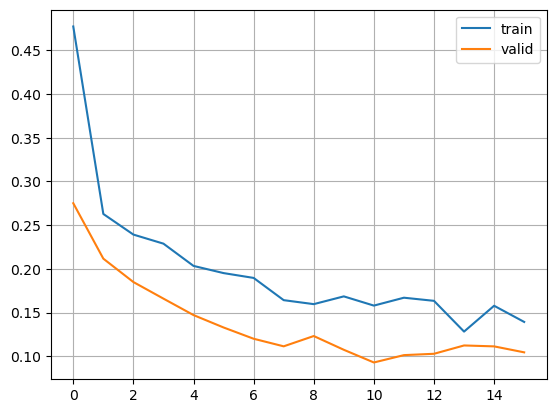

In [39]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, label='valid')
plt.legend(loc="best")
plt.grid("on")
plt.show()

### Metrics

Print out appropriate metrics for the task

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, classification_report

with torch.no_grad():
  model.eval()
  pred = model(torch.from_numpy(X_test).to(device).to(torch.float32))
  pred_classes = (pred >= 0.5).to(torch.float32)
  confusion = confusion_matrix(y_test.values,pred_classes.cpu())
  print(f"Confusion matrix: \n{confusion} \n\n")
  f2 = fbeta_score(y_test.values,pred_classes.cpu(),beta=2)
  print(f"F2-Score: {round(f2,4)}\n\n")
  report = classification_report(y_test.values,pred_classes.cpu())
  print(f"Classification report:\n{report}")

Confusion matrix: 
[[180   5]
 [  2  18]] 


F2-Score: 0.8738


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       185
           1       0.78      0.90      0.84        20

    accuracy                           0.97       205
   macro avg       0.89      0.94      0.91       205
weighted avg       0.97      0.97      0.97       205



In [41]:
wrong_predictions = pred_classes.squeeze().cpu().numpy() != y_test.values

In [42]:
mislabeled_indices = y_test[wrong_predictions].index

In [43]:
data_raw.loc[mislabeled_indices,:]

,dexnum,name,generation,type1,type2,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary
580,445,Garchomp,4,Dragon,Ground,1.9,95.0,108,130,95,80,85,102,600,0
3,1022,Iron Boulder,9,Rock,Psychic,1.5,162.5,90,120,80,68,108,124,590,0
231,794,Buzzwole,7,Bug,Fighting,2.4,333.6,107,139,139,53,53,79,570,0
10,1015,Munkidori,9,Poison,Psychic,1.0,12.2,88,75,66,130,90,106,555,1
319,706,Goodra,6,Dragon,NaN,2.0,150.5,90,100,70,110,150,80,600,0
5,1020,Gouging Fire,9,Fire,Dragon,3.5,590.0,105,115,121,65,93,91,590,0
235,790,Cosmoem,7,Psychic,NaN,0.1,999.9,43,29,131,29,131,37,400,1


We didn't catch 4 legendaries! :(

Notice how the errors are mostly some extreme versions of pokemons, which indeed look legendary.  

Did you manage to catch them all?

______________________________________________________________________________

This notebook is largely inspired (with some improvements) by a video featured on [Data Every Day](https://www.youtube.com/watch?v=3Fr1npNxkJk).